# Short reads methods comparison

- Author: Francisco M Martin Zamora
- Date: 8 to 10 Sep 2025

## 1. Objective

We want to compare the agreement or lack thereof of the different splicing analysis methods we have tested for short reads.

## 2. Data preparation and loading

Load libraries of interest:

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import glob
from scipy import stats

from mplcursors import cursor


Set relevant directories and paths to the files of interest:

In [48]:
hackathon_dir = "/weka/projects/bioinf/Data/hackathon_splicing"
suppa_dir = hackathon_dir + "/suppa2"
isoform_switch_analyzer_dir = hackathon_dir + "/isoform_switch_analyzer"
output_dir = hackathon_dir + "/short_read_methods_comparison"

Plotting parameters:

In [49]:
plt.rcParams['figure.dpi'] = 300

### 2.1. Load data from SUPPA2

In [50]:
# Function to get all files matching a pattern
def get_files(pattern):
    return glob.glob(os.path.join(suppa_dir, pattern))

# Get PSI files
psi_files = {'H9': {}, 'K562': {}}
for file in get_files('salmon_*_*.psi'):
    filename = os.path.basename(file)
    parts = filename.replace('salmon_', '').replace('.psi', '').split('_')
    if len(parts) == 2:  # Ensure we have both cell line and event type
        cell_line, event_type = parts
        psi_files[cell_line][event_type] = file

# Get dPSI files
dpsi_files = {}
for file in get_files('salmon.differential_splicing_*.dpsi'):
    filename = os.path.basename(file)
    event_type = filename.replace('salmon.differential_splicing_', '').replace('.dpsi', '')
    dpsi_files[event_type] = file

# Get avglogtpm files
avglogtpm_files = {}
for file in get_files('salmon.differential_splicing_*_avglogtpm.tab'):
    filename = os.path.basename(file)
    event_type = filename.replace('salmon.differential_splicing_', '').replace('_avglogtpm.tab', '')
    avglogtpm_files[event_type] = file

In [51]:
print("---PSI files---")
for cell_line, events in psi_files.items():
    print(f"\n{cell_line}:")
    for event_type, path in sorted(events.items()):
        print(f"- {event_type}: {path}")

print("\n---DPSI files---")
for event_type, path in sorted(dpsi_files.items()):
    print(f"- {event_type}: {path}")

print("\n---AvgLogTPM files---")
for event_type, path in sorted(avglogtpm_files.items()):
    print(f"- {event_type}: {path}")

---PSI files---

H9:
- A3: /weka/projects/bioinf/Data/hackathon_splicing/suppa2/salmon_H9_A3.psi
- A5: /weka/projects/bioinf/Data/hackathon_splicing/suppa2/salmon_H9_A5.psi
- AF: /weka/projects/bioinf/Data/hackathon_splicing/suppa2/salmon_H9_AF.psi
- AL: /weka/projects/bioinf/Data/hackathon_splicing/suppa2/salmon_H9_AL.psi
- MX: /weka/projects/bioinf/Data/hackathon_splicing/suppa2/salmon_H9_MX.psi
- RI: /weka/projects/bioinf/Data/hackathon_splicing/suppa2/salmon_H9_RI.psi
- SE: /weka/projects/bioinf/Data/hackathon_splicing/suppa2/salmon_H9_SE.psi
- isoform: /weka/projects/bioinf/Data/hackathon_splicing/suppa2/salmon_H9_isoform.psi

K562:
- A3: /weka/projects/bioinf/Data/hackathon_splicing/suppa2/salmon_K562_A3.psi
- A5: /weka/projects/bioinf/Data/hackathon_splicing/suppa2/salmon_K562_A5.psi
- AF: /weka/projects/bioinf/Data/hackathon_splicing/suppa2/salmon_K562_AF.psi
- AL: /weka/projects/bioinf/Data/hackathon_splicing/suppa2/salmon_K562_AL.psi
- MX: /weka/projects/bioinf/Data/hackathon

Now we can load them:

In [52]:
# Define the order of event types
event_order = ['A3', 'A5', 'AF', 'AL', 'MX', 'RI', 'SE', 'isoform']

# Dictionaries to store the loaded dataframes
psi_dict = {'H9': {}, 'K562': {}}
dpsi_dict = {}
avglogtpm_dict = {}

# Load PSI files in order
for cell_line in ['H9', 'K562']:
    for event_type in event_order:
        if event_type in psi_files[cell_line]:
            psi_dict[cell_line][event_type] = pd.read_csv(psi_files[cell_line][event_type], sep='\t')

# Load dPSI files in order
for event_type in event_order:
    if event_type in dpsi_files:
        dpsi_dict[event_type] = pd.read_csv(dpsi_files[event_type], sep='\t')

# Load avglogtpm files in order
for event_type in event_order:
    if event_type in avglogtpm_files:
        df = pd.read_csv(avglogtpm_files[event_type], sep='\t', header=None, index_col=0)
        df.index.name = None
        df.rename(columns={1: "avglogtpm"}, inplace=True)
        avglogtpm_dict[event_type] = df

Let's load a transcript to gene correspondence file too:

In [53]:
tx2gene = pd.read_csv("/home/fmartinzamora/datasets/altos-lab-bioinf/CI/Fran/" + \
    "hackathon_splicing/illumina_processed/star_salmon/tx2gene.tsv", sep="\t")
tx2genename = tx2gene.set_index('transcript_id')['gene_name'].to_dict()
geneid2name = tx2gene.set_index('gene_id')['gene_name'].to_dict()

Let's check the shape of these files. For the case of the PSI and delta PSI files, these should have the same number of rows, as those are the actual events and isoforms:

In [54]:
print("---PSI files---")
for cell_line in psi_dict:
    print(f"\n{cell_line}:")
    for event_type, df in psi_dict[cell_line].items():
        print(f"  {event_type}: {df.shape[0]} events, {df.shape[1]} samples")

print("\n---dPSI files---")
for event_type, df in dpsi_dict.items():
    print(f"  {event_type}: {df.shape[0]} events, {df.shape[1]} columns")

---PSI files---

H9:
  A3: 23990 events, 2 samples
  A5: 21502 events, 2 samples
  AF: 128627 events, 2 samples
  AL: 44778 events, 2 samples
  MX: 10242 events, 2 samples
  RI: 10453 events, 2 samples
  SE: 56513 events, 2 samples
  isoform: 252301 events, 2 samples

K562:
  A3: 23990 events, 2 samples
  A5: 21502 events, 2 samples
  AF: 128627 events, 2 samples
  AL: 44778 events, 2 samples
  MX: 10242 events, 2 samples
  RI: 10453 events, 2 samples
  SE: 56513 events, 2 samples
  isoform: 252301 events, 2 samples

---dPSI files---
  A3: 23990 events, 2 columns
  A5: 21502 events, 2 columns
  AF: 128627 events, 2 columns
  AL: 44778 events, 2 columns
  MX: 10242 events, 2 columns
  RI: 10453 events, 2 columns
  SE: 56513 events, 2 columns
  isoform: 252296 events, 2 columns


In the case of the AvgLogTPM files, there should be less rows:

In [55]:
print("---AvgLogTPM files---")
for event_type, df in avglogtpm_dict.items():
    print(f"  {event_type}: {df.shape[0]} events, {df.shape[1]} columns")

---AvgLogTPM files---
  A3: 15110 events, 1 columns
  A5: 13259 events, 1 columns
  AF: 46759 events, 1 columns
  AL: 13191 events, 1 columns
  MX: 3477 events, 1 columns
  RI: 7597 events, 1 columns
  SE: 34098 events, 1 columns
  isoform: 166759 events, 1 columns


Let's visualise an example of each file type:

In [56]:
psi_dict['H9']['isoform'].head(10)

SGNex_H9_Illumina_replicate2_run1  \
ENSG00000160072;ENST00000673477                           0.055639   
ENSG00000160072;ENST00000308647                           0.369074   
ENSG00000160072;ENST00000472194                           0.061047   
ENSG00000160072;ENST00000378736                           0.424519   
ENSG00000160072;ENST00000485748                           0.055994   
ENSG00000160072;ENST00000474481                           0.033727   
ENSG00000279928;ENST00000624431                                NaN   
ENSG00000228037;ENST00000424215                                NaN   
ENSG00000142611;ENST00000511072                           0.000000   
ENSG00000142611;ENST00000607632                           0.575920   

                                 SGNex_H9_Illumina_replicate3_run1  
ENSG00000160072;ENST00000673477                           0.058876  
ENSG00000160072;ENST00000308647                           0.404611  
ENSG00000160072;ENST00000472194                           0.063513  
ENSG00000160072;ENST00000378736                           0.362744  
ENSG00000160072;ENST00000485748                           0.073282  
ENSG00000160072;ENST00000474481                           0.036974  
ENSG00000279928;ENST00000624431                                NaN  
ENSG00000228037;ENST00000424215                                NaN  
ENSG00000142611;ENST00000511072                           0.000000  
ENSG00000142611;ENST00000607632                           0.000000

In [57]:
dpsi_dict['isoform'].head(10)

salmon_H9_isoform-salmon_K562_isoform_dPSI  \
ENSG00000000003;ENST00000373020                                    0.420224   
ENSG00000000003;ENST00000494424                                    0.000000   
ENSG00000000003;ENST00000496771                                   -0.075621   
ENSG00000000003;ENST00000612152                                   -0.002450   
ENSG00000000003;ENST00000614008                                   -0.342152   
ENSG00000000005;ENST00000373031                                    0.521730   
ENSG00000000005;ENST00000485971                                   -0.521730   
ENSG00000000419;ENST00000371582                                    0.069390   
ENSG00000000419;ENST00000371584                                    0.017048   
ENSG00000000419;ENST00000371588                                   -0.164718   

                                 salmon_H9_isoform-salmon_K562_isoform_p-val  
ENSG00000000003;ENST00000373020                                     0.067433  
ENSG00000000003;ENST00000494424                                     1.000000  
ENSG00000000003;ENST00000496771                                     0.237263  
ENSG00000000003;ENST00000612152                                     1.000000  
ENSG00000000003;ENST00000614008                                     0.067433  
ENSG00000000005;ENST00000373031                                     0.027473  
ENSG00000000005;ENST00000485971                                     0.027473  
ENSG00000000419;ENST00000371582                                     0.063936  
ENSG00000000419;ENST00000371584                                     1.000000  
ENSG00000000419;ENST00000371588                                     0.000000

In [58]:
avglogtpm_dict['isoform'].head(10)

avglogtpm
ENSG00000160072;ENST00000673477   1.710206
ENSG00000160072;ENST00000472194   1.710206
ENSG00000160072;ENST00000378736   1.710206
ENSG00000160072;ENST00000485748   1.710206
ENSG00000160072;ENST00000474481   1.710206
ENSG00000160072;ENST00000308647   1.710206
ENSG00000142611;ENST00000511072  -0.829460
ENSG00000142611;ENST00000607632  -0.829460
ENSG00000142611;ENST00000378391  -0.829460
ENSG00000142611;ENST00000514189  -0.829460

### 2.2. Load data from IsoformSwitchAnalyzeR

In [59]:
isoform_switch_analyzer_quantification = pd.read_csv(isoform_switch_analyzer_dir + "/isoformRepIF_Illumina.csv", sep = ',', index_col=0)
isoform_switch_analyzer_differential_splicing = pd.read_csv(isoform_switch_analyzer_dir + "/isoform_deltaIF_Illumina.csv", sep = ',', index_col=0)
isoform_switch_analyzer_quantification.index.name = None
isoform_switch_analyzer_differential_splicing.index.name = None

Let's load a transcript to gene correspondence file too:

In [60]:
tx2gene = pd.read_csv("/home/fmartinzamora/datasets/altos-lab-bioinf/CI/Fran/" + \
    "hackathon_splicing/illumina_processed/star_salmon/tx2gene.tsv", sep="\t")
tx2geneid = tx2gene.set_index('transcript_id')['gene_id'].to_dict()
tx2genename = tx2gene.set_index('transcript_id')['gene_name'].to_dict()
geneid2name = tx2gene.set_index('gene_id')['gene_name'].to_dict()

Let's add the gene ID information to these objects:

In [61]:
isoform_switch_analyzer_quantification.index = [tx2geneid[i]+';'+i for i in isoform_switch_analyzer_quantification.index]
isoform_switch_analyzer_differential_splicing.index = [tx2geneid[i]+';'+i for i in isoform_switch_analyzer_differential_splicing.index]

Let's visualise the objects:

In [62]:
isoform_switch_analyzer_quantification

SGNex_H9_Illumina_replicate2_run1  \
ENSG00000237491;ENST00000457084                             0.2824   
ENSG00000237491;ENST00000665867                             0.0000   
ENSG00000237491;ENST00000669749                             0.0000   
ENSG00000237491;ENST00000609830                             0.2103   
ENSG00000237491;ENST00000443772                             0.0269   
...                                                            ...   
ENSG00000182484;ENST00000479401                             0.2062   
ENSG00000182484;ENST00000492963                             0.0729   
ENSG00000182484;ENST00000460206                             0.1700   
ENSG00000182484;ENST00000482170                             0.0000   
ENSG00000182484;ENST00000483286                             0.3787   

                                 SGNex_H9_Illumina_replicate3_run1  \
ENSG00000237491;ENST00000457084                             0.2994   
ENSG00000237491;ENST00000665867                             0.0279   
ENSG00000237491;ENST00000669749                             0.0397   
ENSG00000237491;ENST00000609830                             0.0000   
ENSG00000237491;ENST00000443772                             0.0655   
...                                                            ...   
ENSG00000182484;ENST00000479401                             0.1429   
ENSG00000182484;ENST00000492963                             0.0758   
ENSG00000182484;ENST00000460206                             0.2500   
ENSG00000182484;ENST00000482170                             0.0065   
ENSG00000182484;ENST00000483286                             0.2886   

                                 SGNex_K562_Illumina_replicate3_run1  \
ENSG00000237491;ENST00000457084                               0.1701   
ENSG00000237491;ENST00000665867                               0.0254   
ENSG00000237491;ENST00000669749                               0.0000   
ENSG00000237491;ENST00000609830                               0.0506   
ENSG00000237491;ENST00000443772                               0.0034   
...                                                              ...   
ENSG00000182484;ENST00000479401                               0.0000   
ENSG00000182484;ENST00000492963                               0.1645   
ENSG00000182484;ENST00000460206                               0.1502   
ENSG00000182484;ENST00000482170                               0.0141   
ENSG00000182484;ENST00000483286                               0.4219   

                                 SGNex_K562_Illumina_replicate4_run1  
ENSG00000237491;ENST00000457084                               0.0969  
ENSG00000237491;ENST00000665867                               0.0000  
ENSG00000237491;ENST00000669749                               0.0067  
ENSG00000237491;ENST00000609830                               0.0538  
ENSG00000237491;ENST00000443772                               0.0055  
...                                                              ...  
ENSG00000182484;ENST00000479401                               0.0089  
ENSG00000182484;ENST00000492963                               0.1212  
ENSG00000182484;ENST00000460206                               0.2009  
ENSG00000182484;ENST00000482170                               0.0563  
ENSG00000182484;ENST00000483286                               0.4794  

[19800 rows x 4 columns]

In [63]:
isoform_switch_analyzer_differential_splicing

dIF      padj
ENSG00000237491;ENST00000457084 -0.15740  0.084451
ENSG00000237491;ENST00000665867 -0.00125  0.915252
ENSG00000237491;ENST00000669749 -0.01650  0.676967
ENSG00000237491;ENST00000609830 -0.05295  0.900783
ENSG00000237491;ENST00000443772 -0.04175  0.029540
...                                  ...       ...
ENSG00000182484;ENST00000479401 -0.17010  0.003974
ENSG00000182484;ENST00000492963  0.06850  0.015171
ENSG00000182484;ENST00000460206 -0.03445  0.701265
ENSG00000182484;ENST00000482170  0.03195  0.201083
ENSG00000182484;ENST00000483286  0.11700  0.120648

[19800 rows x 2 columns]

## 3. Correlation of quantification metrics

Let's compare the quantifications that the different tools have performed:

In [64]:
suppa2_quantification_isoform = pd.concat([psi_dict['H9']['isoform'], psi_dict['K562']['isoform']], axis=1)
common_indices = suppa2_quantification_isoform.index.intersection(avglogtpm_dict['isoform'].index)
suppa2_quantification_isoform = suppa2_quantification_isoform.loc[common_indices]
avglogtpm_filtered = avglogtpm_dict['isoform'].loc[common_indices]
suppa2_quantification_isoform_above_zero = (
    suppa2_quantification_isoform
    .loc[avglogtpm_filtered['avglogtpm'] > 0]
    .sort_index()
)
suppa2_quantification_isoform_above_zero

SGNex_H9_Illumina_replicate2_run1  \
ENSG00000000003;ENST00000373020                           0.585488   
ENSG00000000003;ENST00000494424                           0.000000   
ENSG00000000003;ENST00000496771                           0.091395   
ENSG00000000003;ENST00000612152                           0.001357   
ENSG00000000003;ENST00000614008                           0.321760   
...                                                            ...   
ENSG00000291270;ENST00000545364                           0.275921   
ENSG00000291270;ENST00000545970                           0.000000   
ENSG00000291272;ENST00000424133                           1.000000   
ENSG00000291273;ENST00000538100                           1.000000   
ENSG00000291283;ENST00000499314                           1.000000   

                                 SGNex_H9_Illumina_replicate3_run1  \
ENSG00000000003;ENST00000373020                           0.574065   
ENSG00000000003;ENST00000494424                           0.000000   
ENSG00000000003;ENST00000496771                           0.059848   
ENSG00000000003;ENST00000612152                           0.003543   
ENSG00000000003;ENST00000614008                           0.362545   
...                                                            ...   
ENSG00000291270;ENST00000545364                           0.265497   
ENSG00000291270;ENST00000545970                           0.000000   
ENSG00000291272;ENST00000424133                           1.000000   
ENSG00000291273;ENST00000538100                           1.000000   
ENSG00000291283;ENST00000499314                           1.000000   

                                 SGNex_K562_Illumina_replicate3_run1  \
ENSG00000000003;ENST00000373020                             1.000000   
ENSG00000000003;ENST00000494424                             0.000000   
ENSG00000000003;ENST00000496771                             0.000000   
ENSG00000000003;ENST00000612152                             0.000000   
ENSG00000000003;ENST00000614008                             0.000000   
...                                                              ...   
ENSG00000291270;ENST00000545364                             0.449742   
ENSG00000291270;ENST00000545970                             0.000000   
ENSG00000291272;ENST00000424133                             1.000000   
ENSG00000291273;ENST00000538100                             1.000000   
ENSG00000291283;ENST00000499314                             1.000000   

                                 SGNex_K562_Illumina_replicate4_run1  
ENSG00000000003;ENST00000373020                             1.000000  
ENSG00000000003;ENST00000494424                             0.000000  
ENSG00000000003;ENST00000496771                             0.000000  
ENSG00000000003;ENST00000612152                             0.000000  
ENSG00000000003;ENST00000614008                             0.000000  
...                                                              ...  
ENSG00000291270;ENST00000545364                             0.554243  
ENSG00000291270;ENST00000545970                             0.000000  
ENSG00000291272;ENST00000424133                             1.000000  
ENSG00000291273;ENST00000538100                             1.000000  
ENSG00000291283;ENST00000499314                             1.000000  

[141692 rows x 4 columns]

In [65]:
isoform_switch_analyzer_quantification.sort_index(inplace=True)
isoform_switch_analyzer_quantification

SGNex_H9_Illumina_replicate2_run1  \
ENSG00000001460;ENST00000003583                             0.1122   
ENSG00000001460;ENST00000337248                             0.5936   
ENSG00000001460;ENST00000435187                             0.0455   
ENSG00000001460;ENST00000438866                             0.0651   
ENSG00000001460;ENST00000468303                             0.0060   
...                                                            ...   
ENSG00000291258;ENST00000564604                             0.0000   
ENSG00000291258;ENST00000566178                             0.0940   
ENSG00000291266;ENST00000411546                             0.4690   
ENSG00000291270;ENST00000538166                             0.7241   
ENSG00000291270;ENST00000545364                             0.2759   

                                 SGNex_H9_Illumina_replicate3_run1  \
ENSG00000001460;ENST00000003583                             0.2394   
ENSG00000001460;ENST00000337248                             0.4894   
ENSG00000001460;ENST00000435187                             0.0215   
ENSG00000001460;ENST00000438866                             0.0000   
ENSG00000001460;ENST00000468303                             0.0063   
...                                                            ...   
ENSG00000291258;ENST00000564604                             0.0000   
ENSG00000291258;ENST00000566178                             0.0975   
ENSG00000291266;ENST00000411546                             0.6162   
ENSG00000291270;ENST00000538166                             0.7345   
ENSG00000291270;ENST00000545364                             0.2655   

                                 SGNex_K562_Illumina_replicate3_run1  \
ENSG00000001460;ENST00000003583                               0.2141   
ENSG00000001460;ENST00000337248                               0.5392   
ENSG00000001460;ENST00000435187                               0.0394   
ENSG00000001460;ENST00000438866                               0.0333   
ENSG00000001460;ENST00000468303                               0.0283   
...                                                              ...   
ENSG00000291258;ENST00000564604                               0.2412   
ENSG00000291258;ENST00000566178                               0.1147   
ENSG00000291266;ENST00000411546                               0.8933   
ENSG00000291270;ENST00000538166                               0.5503   
ENSG00000291270;ENST00000545364                               0.4497   

                                 SGNex_K562_Illumina_replicate4_run1  
ENSG00000001460;ENST00000003583                               0.1023  
ENSG00000001460;ENST00000337248                               0.5734  
ENSG00000001460;ENST00000435187                               0.0240  
ENSG00000001460;ENST00000438866                               0.0337  
ENSG00000001460;ENST00000468303                               0.0133  
...                                                              ...  
ENSG00000291258;ENST00000564604                               0.1730  
ENSG00000291258;ENST00000566178                               0.1096  
ENSG00000291266;ENST00000411546                               0.8952  
ENSG00000291270;ENST00000538166                               0.4458  
ENSG00000291270;ENST00000545364                               0.5542  

[19800 rows x 4 columns]

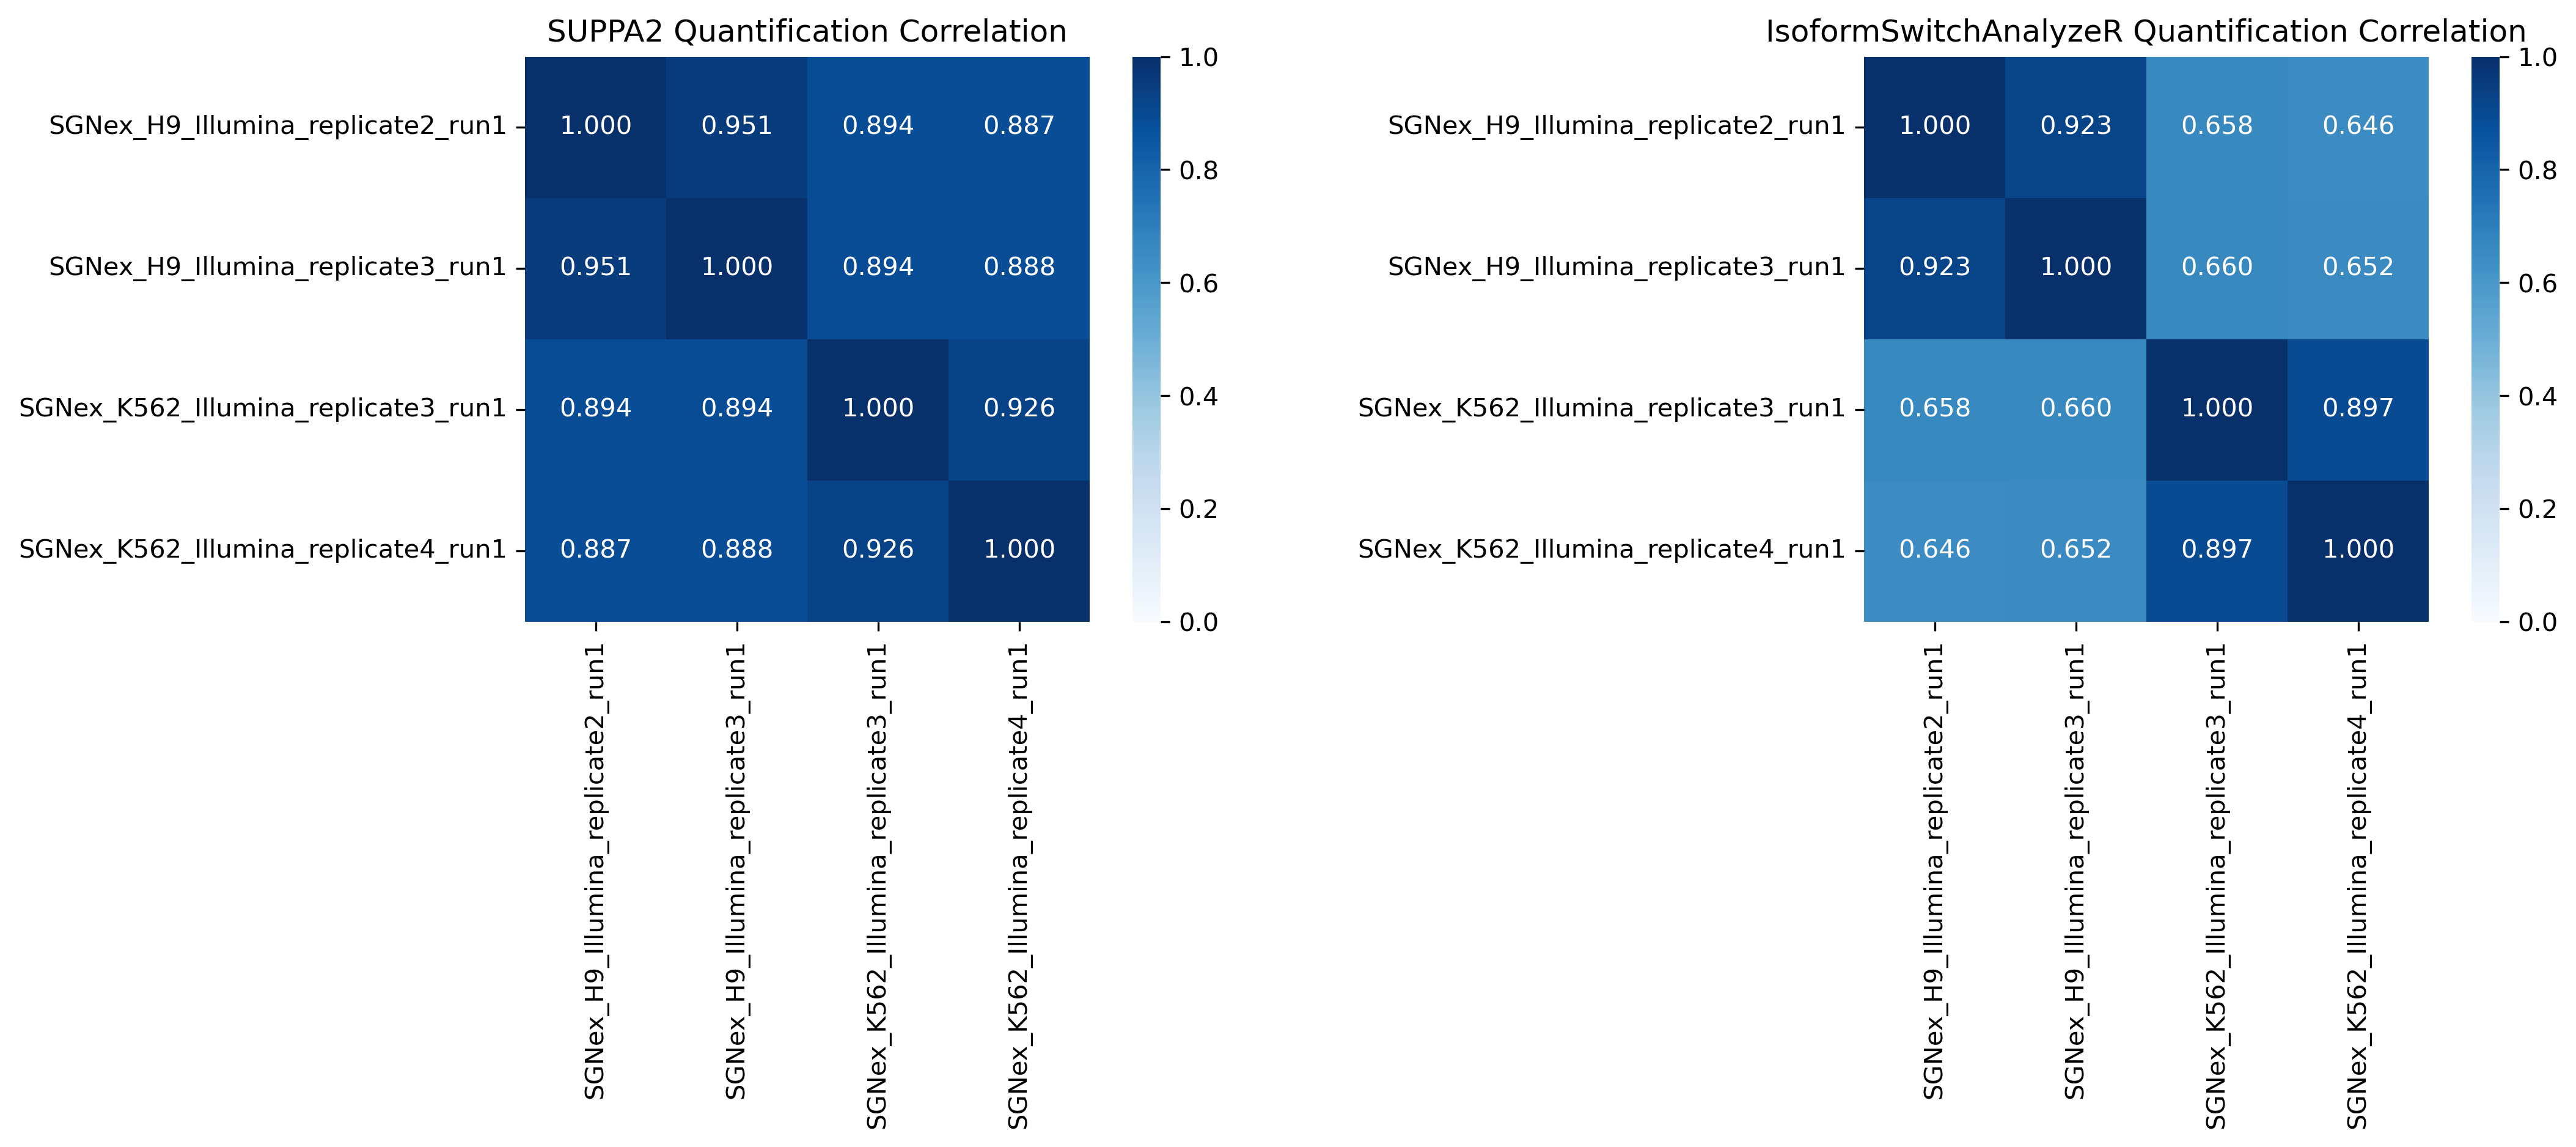

In [66]:
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Correlation plot for suppa2_quantification_isoform_above_zero
corr_suppa2 = suppa2_quantification_isoform_above_zero.corr()
sns.heatmap(corr_suppa2, 
            annot=True, 
            cmap='Blues', 
            vmin=0, 
            vmax=1, 
            ax=ax1,
            fmt='.3f',
            square=True)
ax1.set_title('SUPPA2 Quantification Correlation')

# Correlation plot for isoform_switch_analyzer_quantification
corr_isa = isoform_switch_analyzer_quantification.corr()
sns.heatmap(corr_isa, 
            annot=True, 
            cmap='Blues', 
            vmin=0, 
            vmax=1, 
            ax=ax2,
            fmt='.3f',
            square=True)
ax2.set_title('IsoformSwitchAnalyzeR Quantification Correlation')

# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.show()

Granted, the dimensions of the two tools, even after filtering for average log2(TPM) > 0 are radically different.

In [67]:
suppa2_quantification_isoform_above_zero.shape

(141692, 4)

In [68]:
isoform_switch_analyzer_quantification.shape

(19800, 4)

Now let's compare those transcripts present in both methods:

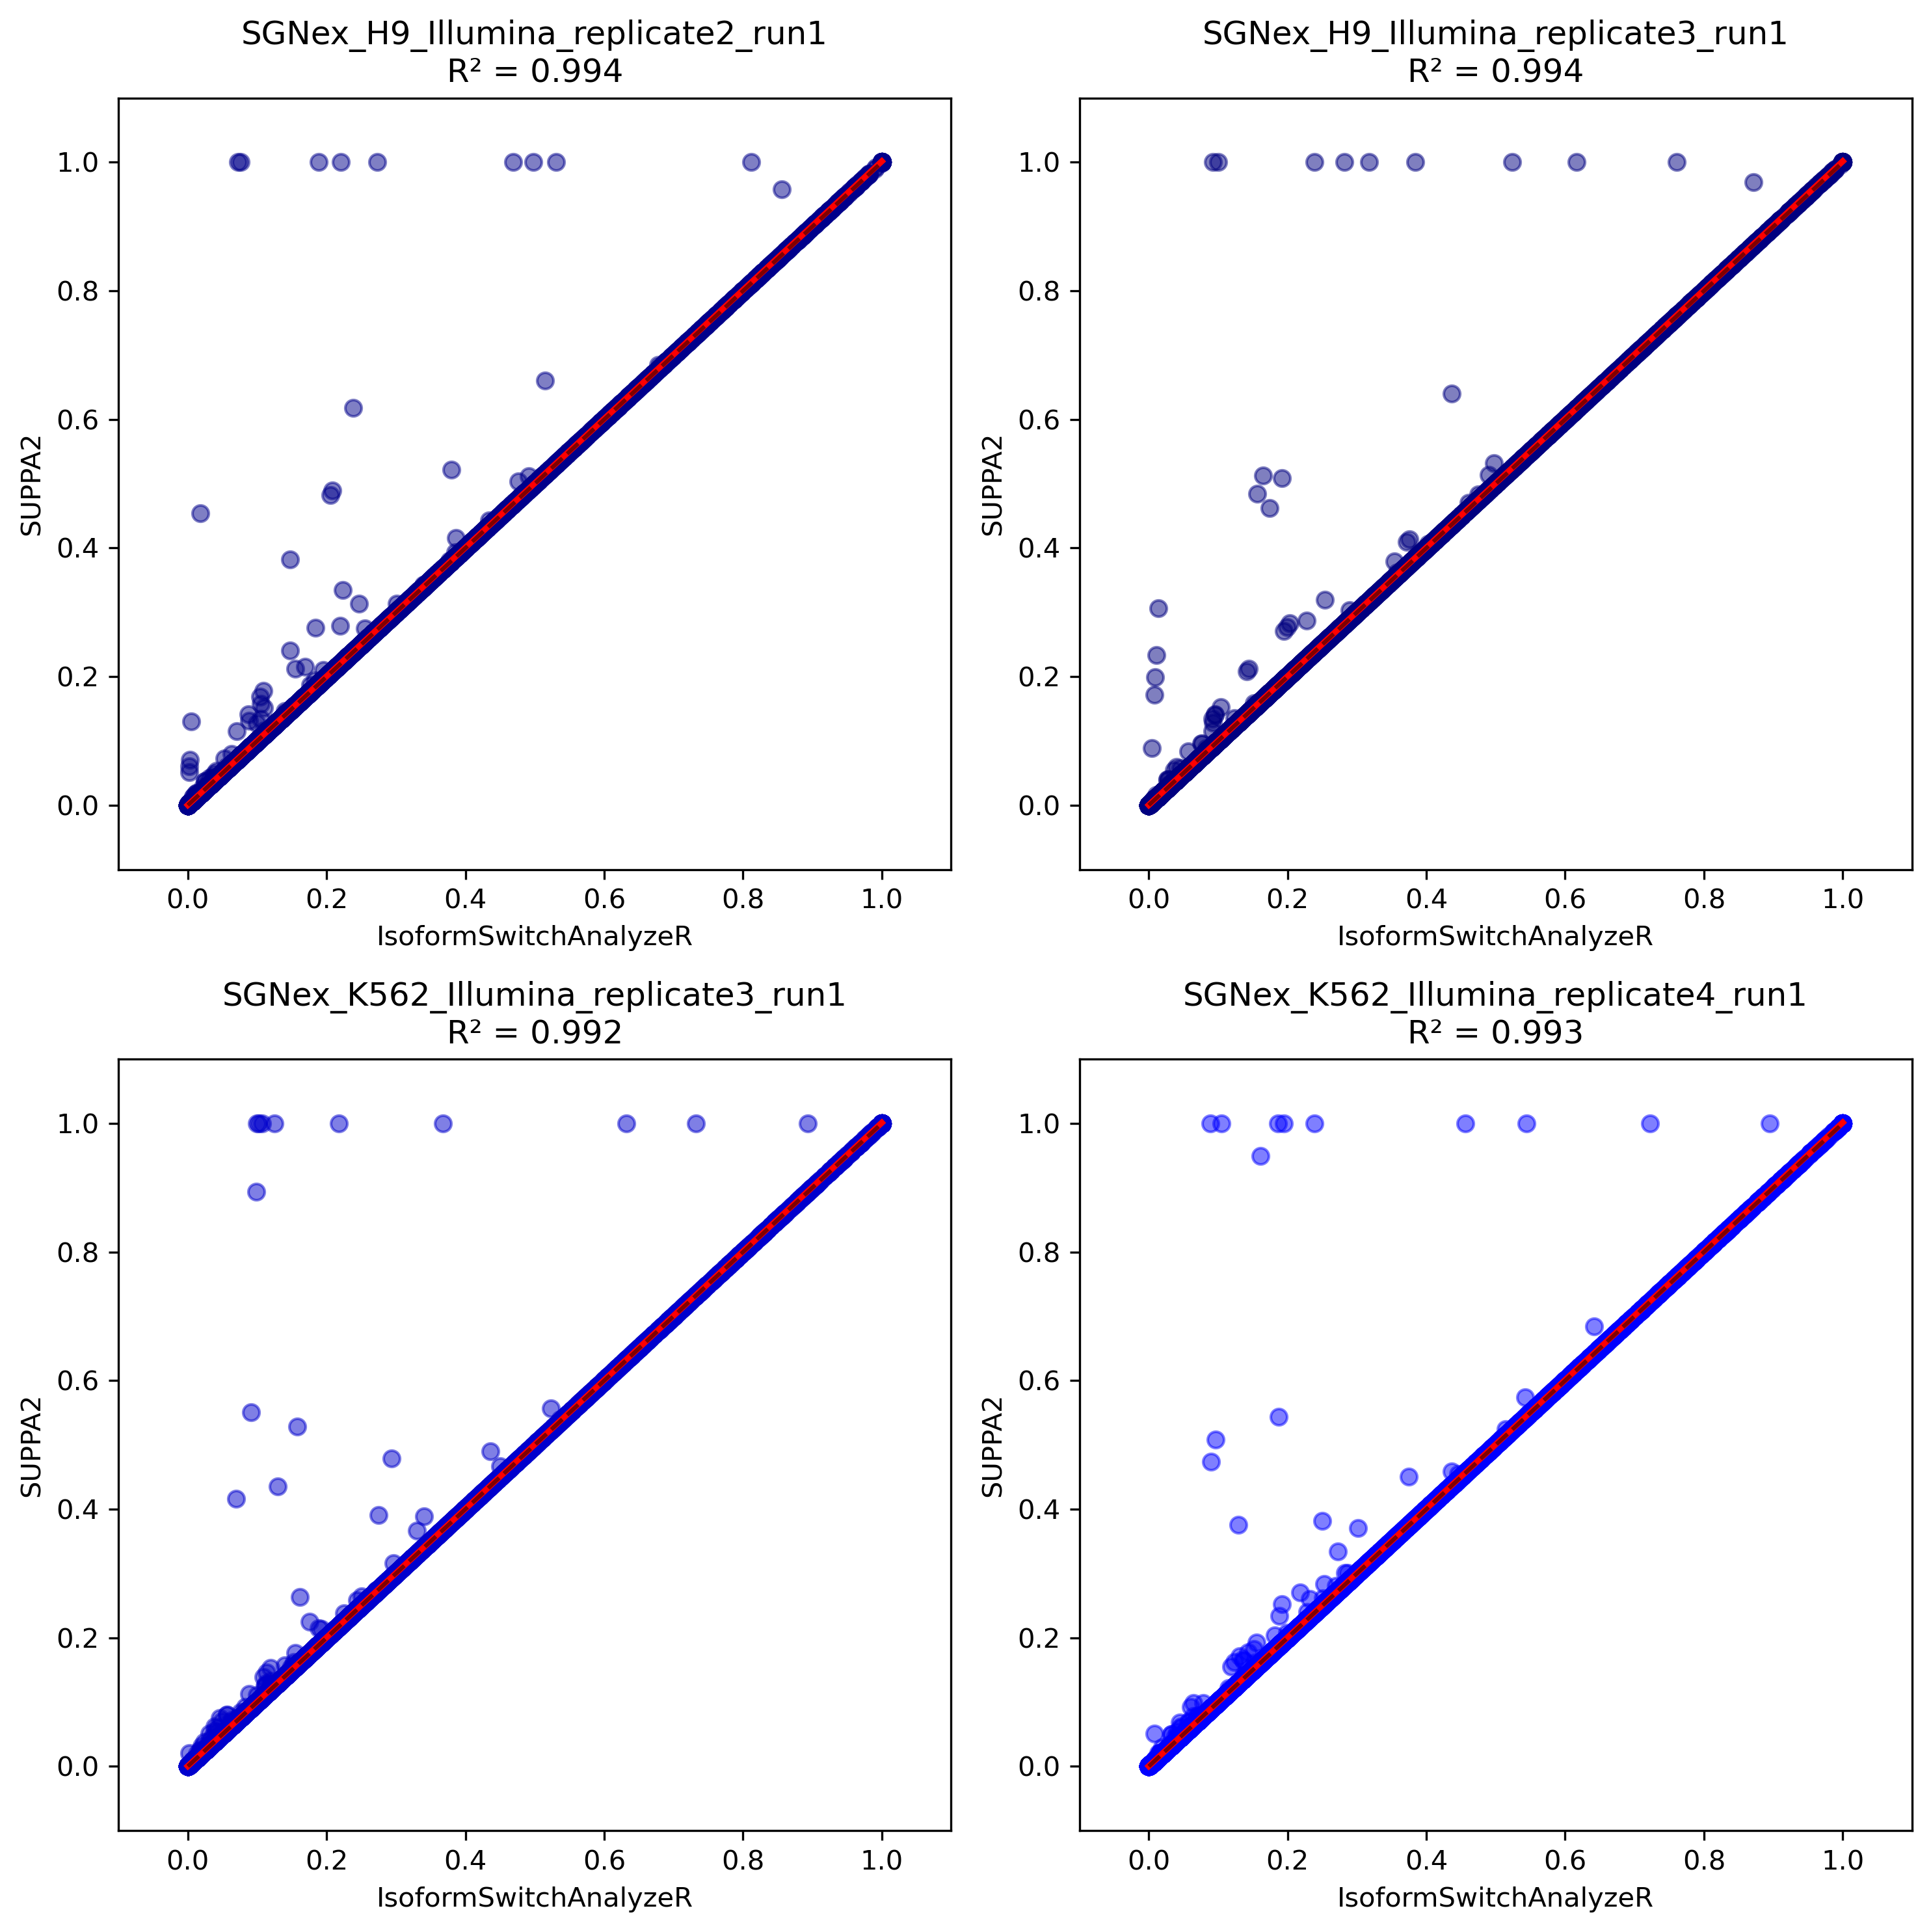

In [69]:
# Get common indices between the two dataframes
common_indices = suppa2_quantification_isoform_above_zero.index.intersection(isoform_switch_analyzer_quantification.index)

# Create a figure with subplots (2x2 grid since we have 4 samples)
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.ravel()  # Flatten axes array for easier iteration

# Colors for each plot
colors = ['darkblue', 'navy', 'mediumblue', 'blue']

# Create scatter plots for each sample
for idx, column in enumerate(suppa2_quantification_isoform_above_zero.columns):
    # Get data for current sample
    x = isoform_switch_analyzer_quantification.loc[common_indices, column]
    y = suppa2_quantification_isoform_above_zero.loc[common_indices, column]
    
    # Calculate R-squared
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    r_squared = r_value**2
    
    # Create scatter plot with regression line and confidence interval
    sns.regplot(x=x, y=y, 
                ax=axes[idx],
                scatter_kws={'alpha':0.5, 'color':colors[idx]},
                line_kws={'color': 'red'},
                ci=95)  # 95% confidence interval
    
    # Customize plot
    axes[idx].set_title(f'{column}\nR² = {r_squared:.3f}')
    axes[idx].set_xlabel('IsoformSwitchAnalyzeR')
    axes[idx].set_ylabel('SUPPA2')
    axes[idx].set_xlim(-0.1, 1.1)
    axes[idx].set_ylim(-0.1, 1.1)
    
    # Add identity line (y=x)
    axes[idx].plot([0, 1], [0, 1], 'k--', alpha=0.5)

plt.tight_layout()
plt.show()

Let's have a look at what those genes are:

In [85]:
# Calculate absolute difference for each gene in each sample
differences = abs(suppa2_quantification_isoform_above_zero.loc[common_indices] - 
                 isoform_switch_analyzer_quantification.loc[common_indices])

# Find genes with large differences (> 0.1 in any sample)
divergent_genes = differences[differences > 0.1].dropna(how='all')
divergent_genes['gene_name'] = [geneid2name[i.split(';')[0]] for i in divergent_genes.index]
divergent_genes['avglogtpm'] = avglogtpm_filtered.loc[divergent_genes.index, 'avglogtpm']

In [86]:
divergent_genes

SGNex_H9_Illumina_replicate2_run1  \
ENSG00000125863;ENST00000399054                           0.281276   
ENSG00000125863;ENST00000652676                           0.276846   
ENSG00000143248;ENST00000428971                                NaN   
ENSG00000180229;ENST00000429257                           0.928000   
ENSG00000183604;ENST00000529428                           0.469000   
ENSG00000185485;ENST00000440850                           0.727300   
ENSG00000231259;ENST00000452554                           0.811700   
ENSG00000232995;ENST00000439699                                NaN   
ENSG00000232995;ENST00000449680                                NaN   
ENSG00000232995;ENST00000451759                           0.125372   
ENSG00000232995;ENST00000528689                                NaN   
ENSG00000232995;ENST00000528818                           0.436802   
ENSG00000277053;ENST00000614592                           0.779100   
ENSG00000284770;ENST00000366601                                NaN   
ENSG00000285053;ENST00000643758                           0.234938   
ENSG00000285053;ENST00000645351                           0.379862   
ENSG00000285508;ENST00000609375                           0.923600   
ENSG00000285723;ENST00000649912                           0.502300   
ENSG00000285793;ENST00000648819                           0.188300   
ENSG00000290387;ENST00000562107                           0.102116   
ENSG00000290763;ENST00000457601                           0.142262   
ENSG00000290871;ENST00000622829                           0.145871   
ENSG00000291087;ENST00000382734                                NaN   
ENSG00000291087;ENST00000609084                                NaN   
ENSG00000291122;ENST00000689058                           0.111549   
ENSG00000291266;ENST00000411546                           0.531000   

                                 SGNex_H9_Illumina_replicate3_run1  \
ENSG00000125863;ENST00000399054                           0.317202   
ENSG00000125863;ENST00000652676                           0.288431   
ENSG00000143248;ENST00000428971                                NaN   
ENSG00000180229;ENST00000429257                           0.907400   
ENSG00000183604;ENST00000529428                           0.616200   
ENSG00000185485;ENST00000440850                           0.718000   
ENSG00000231259;ENST00000452554                           0.761100   
ENSG00000232995;ENST00000439699                           0.223021   
ENSG00000232995;ENST00000449680                           0.163882   
ENSG00000232995;ENST00000451759                                NaN   
ENSG00000232995;ENST00000528689                           0.292151   
ENSG00000232995;ENST00000528818                           0.189766   
ENSG00000277053;ENST00000614592                           0.682100   
ENSG00000284770;ENST00000366601                                NaN   
ENSG00000285053;ENST00000643758                           0.328609   
ENSG00000285053;ENST00000645351                           0.348183   
ENSG00000285508;ENST00000609375                           0.900300   
ENSG00000285723;ENST00000649912                           0.476100   
ENSG00000285793;ENST00000648819                           0.238900   
ENSG00000290387;ENST00000562107                                NaN   
ENSG00000290763;ENST00000457601                                NaN   
ENSG00000290871;ENST00000622829                           0.203458   
ENSG00000291087;ENST00000382734                                NaN   
ENSG00000291087;ENST00000609084                                NaN   
ENSG00000291122;ENST00000689058                                NaN   
ENSG00000291266;ENST00000411546                           0.383800   

                                 SGNex_K562_Illumina_replicate3_run1  \
ENSG00000125863;ENST00000399054                             0.346859   
ENSG00000125863;ENST00000652676                             0.458877   
ENSG00000143248;ENST00000428971    

In [81]:
divergent_genes['gene_name'].unique().tolist()

['MKKS',
 'RGS5',
 'HERC2P3',
 'SMG1P5',
 'SDHAP1',
 'ANAPC1P2',
 'GTF2IP1',
 'TBCE',
 'SORD2P',
 'CRYBB2P1',
 'CASTOR3']

After looking at these genes in a genome browser (e.g., Seqmonk), we have realised that the main issue is that all these genes are annotated more than once as different ENSEMBL gene IDs that are overlapping each other in the same locus. One of the two tools therefore quantifies the PSI or the IF incorrectly.

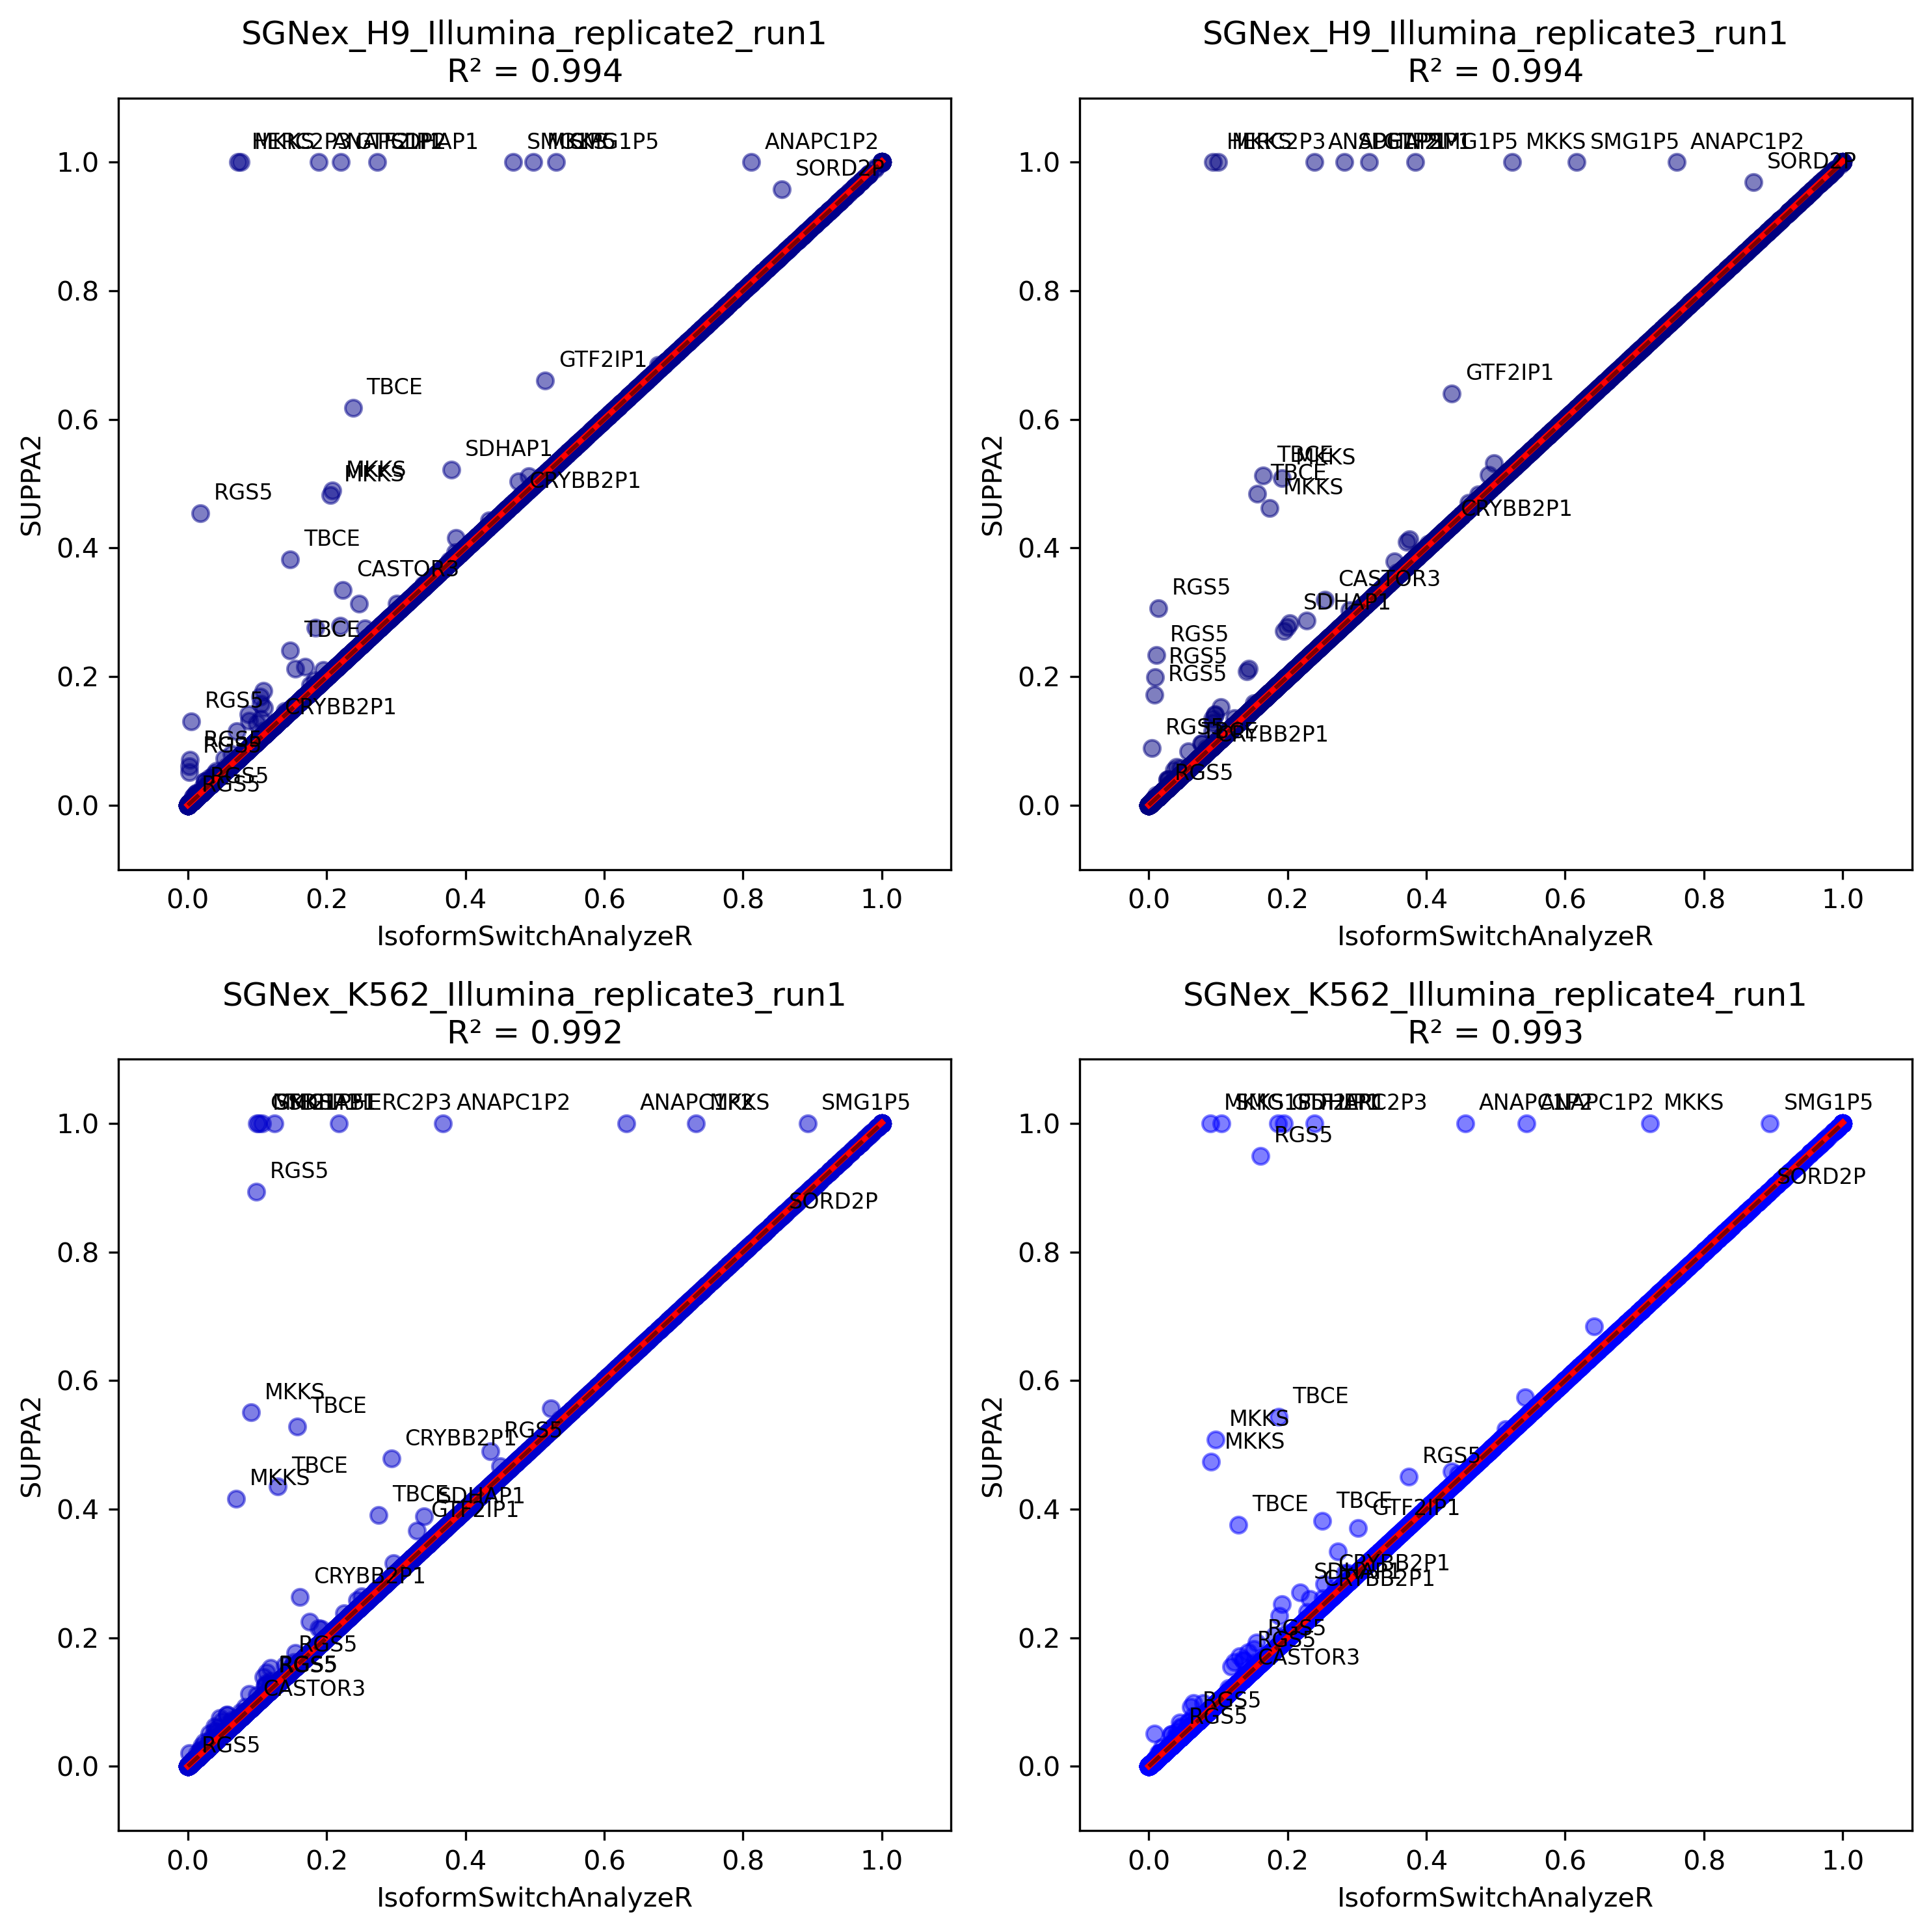

In [87]:
# Get common indices between the two dataframes
common_indices = suppa2_quantification_isoform_above_zero.index.intersection(isoform_switch_analyzer_quantification.index)

# Create a figure with subplots (2x2 grid since we have 4 samples)
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.ravel()  # Flatten axes array for easier iteration

# Colors for each plot
colors = ['darkblue', 'navy', 'mediumblue', 'blue']

# Create scatter plots for each sample
for idx, column in enumerate(suppa2_quantification_isoform_above_zero.columns):
    # Get data for current sample
    x = isoform_switch_analyzer_quantification.loc[common_indices, column]
    y = suppa2_quantification_isoform_above_zero.loc[common_indices, column]
    
    # Calculate R-squared
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    r_squared = r_value**2
    
    # Create scatter plot with regression line and confidence interval
    sns.regplot(x=x, y=y, 
                ax=axes[idx],
                scatter_kws={'alpha':0.5, 'color':colors[idx]},
                line_kws={'color': 'red'},
                ci=95)  # 95% confidence interval
    
    # Add labels for divergent genes
    for gene_idx in divergent_genes.index:
        if gene_idx in x.index and gene_idx in y.index:
            if not pd.isna(x[gene_idx]) and not pd.isna(y[gene_idx]):
                axes[idx].annotate(divergent_genes.loc[gene_idx, 'gene_name'],
                                 (x[gene_idx], y[gene_idx]),
                                 xytext=(5, 5), textcoords='offset points',
                                 fontsize=8)
    
    # Customize plot
    axes[idx].set_title(f'{column}\nR² = {r_squared:.3f}')
    axes[idx].set_xlabel('IsoformSwitchAnalyzeR')
    axes[idx].set_ylabel('SUPPA2')
    axes[idx].set_xlim(-0.1, 1.1)
    axes[idx].set_ylim(-0.1, 1.1)
    
    # Add identity line (y=x)
    axes[idx].plot([0, 1], [0, 1], 'k--', alpha=0.5)

plt.tight_layout()
plt.show()

## 4. Correlation of differential splicing metrics

In [97]:
suppa2_differential_splicing_isoform = dpsi_dict['isoform'].copy()
common_indices = suppa2_differential_splicing_isoform.index.intersection(avglogtpm_dict['isoform'].index)
suppa2_differential_splicing_isoform = suppa2_differential_splicing_isoform.loc[common_indices]
avglogtpm_filtered = avglogtpm_dict['isoform'].loc[common_indices]
suppa2_differential_splicing_isoform_above_zero = (
    suppa2_differential_splicing_isoform
    .loc[avglogtpm_filtered['avglogtpm'] > 0]
    .sort_index()
)
suppa2_differential_splicing_isoform_above_zero

salmon_H9_isoform-salmon_K562_isoform_dPSI  \
ENSG00000000003;ENST00000373020                                    0.420224   
ENSG00000000003;ENST00000494424                                    0.000000   
ENSG00000000003;ENST00000496771                                   -0.075621   
ENSG00000000003;ENST00000612152                                   -0.002450   
ENSG00000000003;ENST00000614008                                   -0.342152   
...                                                                     ...   
ENSG00000291270;ENST00000545364                                    0.231283   
ENSG00000291270;ENST00000545970                                    0.000000   
ENSG00000291272;ENST00000424133                                    0.000000   
ENSG00000291273;ENST00000538100                                    0.000000   
ENSG00000291283;ENST00000499314                                    0.000000   

                                 salmon_H9_isoform-salmon_K562_isoform_p-val  
ENSG00000000003;ENST00000373020                                     0.067433  
ENSG00000000003;ENST00000494424                                     1.000000  
ENSG00000000003;ENST00000496771                                     0.237263  
ENSG00000000003;ENST00000612152                                     1.000000  
ENSG00000000003;ENST00000614008                                     0.067433  
...                                                                      ...  
ENSG00000291270;ENST00000545364                                     0.035964  
ENSG00000291270;ENST00000545970                                     1.000000  
ENSG00000291272;ENST00000424133                                     1.000000  
ENSG00000291273;ENST00000538100                                     1.000000  
ENSG00000291283;ENST00000499314                                     1.000000  

[141692 rows x 2 columns]

In [99]:
isoform_switch_analyzer_differential_splicing.sort_index(inplace=True)
isoform_switch_analyzer_differential_splicing

dIF          padj
ENSG00000001460;ENST00000003583 -0.01760  9.314277e-01
ENSG00000001460;ENST00000337248  0.01480  9.023109e-01
ENSG00000001460;ENST00000435187 -0.00180  9.243336e-01
ENSG00000001460;ENST00000438866  0.00095  7.457891e-01
ENSG00000001460;ENST00000468303  0.01465  4.422219e-01
...                                  ...           ...
ENSG00000291258;ENST00000564604  0.20710  2.407947e-09
ENSG00000291258;ENST00000566178  0.01640  7.367791e-01
ENSG00000291266;ENST00000411546  0.35165  7.182617e-07
ENSG00000291270;ENST00000538166 -0.23125  1.327909e-03
ENSG00000291270;ENST00000545364  0.23125  2.128204e-03

[19800 rows x 2 columns]

/usr/conda/envs/suppa2_env/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/conda/envs/suppa2_env/lib/python3.9/site-packages/numpy/lib/_function_base_impl.py:2767: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/usr/conda/envs/suppa2_env/lib/python3.9/site-packages/numpy/_core/function_base.py:168: RuntimeWarning: invalid value encountered in multiply
  y *= step
/usr/conda/envs/suppa2_env/lib/python3.9/site-packages/numpy/lib/_nanfunctions_impl.py:1634: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,


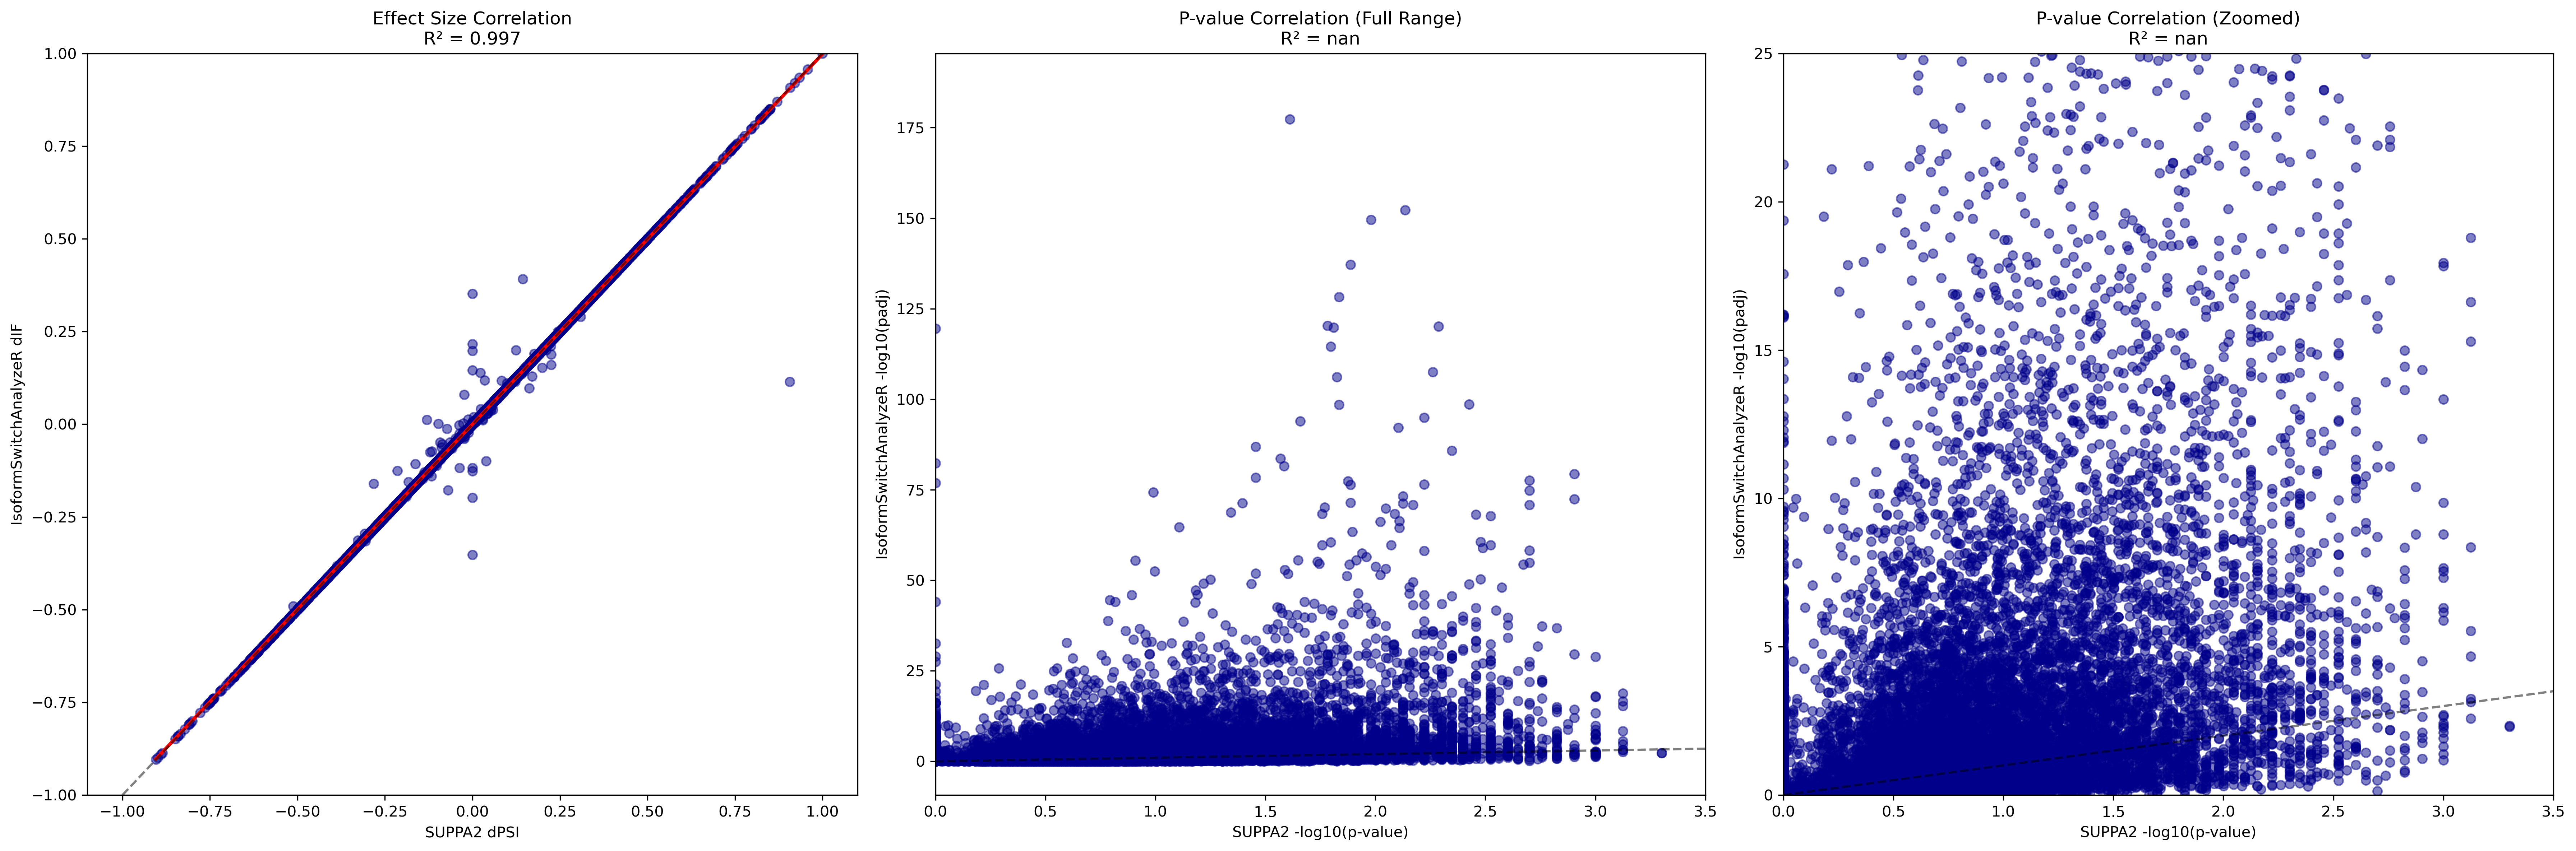

In [112]:
# Get common indices between both DataFrames
common_indices = suppa2_differential_splicing_isoform_above_zero.index.intersection(isoform_switch_analyzer_differential_splicing.index)

# Create figure with three subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))

# First plot: dPSI vs dIF
suppa2_dpsi = suppa2_differential_splicing_isoform_above_zero.loc[common_indices, 'salmon_H9_isoform-salmon_K562_isoform_dPSI']
isa_dif = isoform_switch_analyzer_differential_splicing.loc[common_indices, 'dIF']

# Calculate R-squared for effect sizes
slope1, intercept1, r_value1, p_value1, std_err1 = stats.linregress(suppa2_dpsi, isa_dif)
r_squared1 = r_value1**2

# Effect size plot
sns.regplot(x=suppa2_dpsi, y=isa_dif,
            scatter_kws={'alpha':0.5, 'color':'darkblue'},
            line_kws={'color': 'red'},
            ci=95,
            ax=ax1)

ax1.set_title(f'Effect Size Correlation\nR² = {r_squared1:.3f}')
ax1.set_xlabel('SUPPA2 dPSI')
ax1.set_ylabel('IsoformSwitchAnalyzeR dIF')
ax1.plot([-1, 1], [-1, 1], 'k--', alpha=0.5)
ax1.set_ylim(-1, 1)  # Set y-axis limits for effect size plot

# P-values for both middle and right plots
suppa2_pval = -np.log10(suppa2_differential_splicing_isoform_above_zero.loc[common_indices, 'salmon_H9_isoform-salmon_K562_isoform_p-val'])
isa_pval = -np.log10(isoform_switch_analyzer_differential_splicing.loc[common_indices, 'padj'])

# Calculate R-squared for p-values
slope2, intercept2, r_value2, p_value2, std_err2 = stats.linregress(suppa2_pval, isa_pval)
r_squared2 = r_value2**2

# Middle plot: Full range p-values
sns.regplot(x=suppa2_pval, y=isa_pval,
            scatter_kws={'alpha':0.5, 'color':'darkblue'},
            line_kws={'color': 'red'},
            ci=95,
            ax=ax2)

ax2.set_title(f'P-value Correlation (Full Range)\nR² = {r_squared2:.3f}')
ax2.set_xlabel('SUPPA2 -log10(p-value)')
ax2.set_ylabel('IsoformSwitchAnalyzeR -log10(padj)')
max_val = max(ax2.get_xlim()[1], ax2.get_ylim()[1])
ax2.plot([0, max_val], [0, max_val], 'k--', alpha=0.5)
ax2.set_xlim(0, 3.5)

# Right plot: Zoomed p-values
sns.regplot(x=suppa2_pval, y=isa_pval,
            scatter_kws={'alpha':0.5, 'color':'darkblue'},
            line_kws={'color': 'red'},
            ci=95,
            ax=ax3)

ax3.set_title(f'P-value Correlation (Zoomed)\nR² = {r_squared2:.3f}')
ax3.set_xlabel('SUPPA2 -log10(p-value)')
ax3.set_ylabel('IsoformSwitchAnalyzeR -log10(padj)')
ax3.plot([0, 25], [0, 25], 'k--', alpha=0.5)
ax3.set_xlim(0, 3.5)  # Set x-axis limits for zoomed p-value plot
ax3.set_ylim(0, 25)  # Set y-axis limits for zoomed p-value plot

plt.tight_layout()
plt.show()

In [138]:
# Calculate absolute difference for each gene in each sample
differences = abs(suppa2_differential_splicing_isoform_above_zero['salmon_H9_isoform-salmon_K562_isoform_dPSI'].loc[common_indices] - 
                 isoform_switch_analyzer_differential_splicing['dIF'].loc[common_indices])

# Find genes with large differences (> 0.05 in any sample)
divergent_genes = differences[differences > 0.05].dropna(how='all')
divergent_genes = pd.DataFrame(divergent_genes)
divergent_genes.columns = ['difference']
divergent_genes['gene_name'] = [geneid2name[i.split(';')[0]] for i in divergent_genes.index]
divergent_genes['avglogtpm'] = avglogtpm_filtered.loc[divergent_genes.index, 'avglogtpm']
divergent_genes

difference gene_name  avglogtpm
ENSG00000125863;ENST00000399054    0.080195      MKKS   1.384408
ENSG00000125863;ENST00000652676    0.138741      MKKS   1.384408
ENSG00000143248;ENST00000428971    0.791358      RGS5   0.938780
ENSG00000180229;ENST00000429257    0.145950   HERC2P3   0.307778
ENSG00000183604;ENST00000529428    0.351650    SMG1P5   0.213265
ENSG00000185485;ENST00000440850    0.117600    SDHAP1   0.762811
ENSG00000231259;ENST00000452554    0.198300  ANAPC1P2   0.504134
ENSG00000232995;ENST00000439699    0.116479      RGS5   0.661111
ENSG00000232995;ENST00000449680    0.102851      RGS5   0.661111
ENSG00000232995;ENST00000451759    0.084482      RGS5   0.661111
ENSG00000232995;ENST00000528689    0.142250      RGS5   0.661111
ENSG00000232995;ENST00000528818    0.248100      RGS5   0.661111
ENSG00000277053;ENST00000614592    0.126750   GTF2IP1   1.073080
ENSG00000284770;ENST00000366601    0.064218      TBCE   1.533085
ENSG00000284770;ENST00000643142    0.056253      TBCE   1.533085
ENSG00000285723;ENST00000649912    0.216000      MKKS   1.743732
ENSG00000285793;ENST00000648819    0.198300  ANAPC1P2   0.866588
ENSG00000290387;ENST00000562107    0.099648    SORD2P   1.126997
ENSG00000290763;ENST00000457601    0.060464    SDHAP1   1.336515
ENSG00000290871;ENST00000622829    0.122043   GTF2IP1   1.692533
ENSG00000291087;ENST00000382734    0.107952  CRYBB2P1   1.175854
ENSG00000291087;ENST00000609084    0.064977  CRYBB2P1   1.175854
ENSG00000291122;ENST00000414739    0.076031   CASTOR3   0.901580
ENSG00000291122;ENST00000689058    0.089136   CASTOR3   0.901580
ENSG00000291266;ENST00000411546    0.351650    SMG1P5   0.714796